# Modeling - Final
In this notebook, I have picked the best model from the previously trained Logistic Regression, KNN, Decision Tree, Random Forest, and XGBoost algorithms, trained it on the entire training set and analyzed its performance on the previously unseen test set.

The AUC-ROC for all the tried algorithms are as follows:

| Algorithm           | Mean AUC-ROC | Standard Deviation |
|---------------------|--------------|--------------------|
| Logistic Regression |    0.9624    |       0.0027       |
| K-Nearest Neighbors |    0.9748    |       0.0020       |
| Decision Tree       |    0.9751    |       0.0021       |
| Random Forest       |    0.9827    |       0.0015       |
| XGBoost             |    0.9840    |       0.0014       |

Among all these algorithms, XGBoost outperformed every other algorithm. It has both the highest mean AUC-ROC score and the lowest standard deviation. I'll use this algorithm for building the final classifier.

## Table of Contents:
1. Data Loading
    - Train Data
    - Test Data
2. Preparing Test Data for Modeling
    - Removing Non-Meaningful Variables
    - Checking for Erroneous Rows
    - Missing Values Treatment
    - Creating *is_contract* column
3. Exporting Processed Test Data
4. Modeling
    - Model Training
    - Evaluation
5. Exporting Trained Model

In [1]:
# Importing required libraries and modules
import os
import sys
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from joblib import dump
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             f1_score,
                             roc_auc_score)

In [2]:
# Setting the seed
np.random.seed(42)

## Data Loading

### Train Data

In [3]:
train_prepared = pd.read_csv('../data/processed/train-prepared.csv')

In [4]:
print('Shape=>', train_prepared.shape)
train_prepared.head()

Shape=> (62273, 11)


,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1,1,1.77,7,0.19,1,0,114.1,8.7,0,0
1,1,0,0.05,6,0.59,1,0,12.7,1.3,0,0
2,0,0,1.42,18,0.00,0,0,0.4,0.0,0,1
3,1,0,0.73,20,0.00,1,0,9.3,0.4,0,1
4,1,0,0.25,17,0.00,1,0,6.1,0.5,0,1


In [5]:
# Getting an overview of the dataset
train_prepared.info(show_counts=True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62273 entries, 0 to 62272
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_tv_subscriber             62273 non-null  int64  
 1   is_movie_package_subscriber  62273 non-null  int64  
 2   subscription_age             62273 non-null  float64
 3   bill_avg                     62273 non-null  int64  
 4   remaining_contract           62273 non-null  float64
 5   is_contract                  62273 non-null  int64  
 6   service_failure_count        62273 non-null  int64  
 7   download_avg                 61948 non-null  float64
 8   upload_avg                   61948 non-null  float64
 9   download_over_limit          62273 non-null  int64  
 10  churn                        62273 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 5.2 MB


### Test Data

In [6]:
test = pd.read_csv('../data/interim/test.csv')

In [7]:
print('Shape=>', test.shape)
test.head()

Shape=> (10000, 11)


,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1187227,1,1,2.05,14,0.61,0,30.2,2.3,0,0
1,481052,1,0,3.19,7,0.00,0,7.0,0.6,0,1
2,409792,1,1,6.75,0,NaN,0,0.0,0.0,0,1
3,954134,1,0,3.14,12,0.81,0,189.5,15.4,0,0
4,380945,1,0,6.45,21,0.19,0,20.2,1.4,0,0


In [8]:
# Getting an overview of the dataset
test.info(show_counts=True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           10000 non-null  int64  
 1   is_tv_subscriber             10000 non-null  int64  
 2   is_movie_package_subscriber  10000 non-null  int64  
 3   subscription_age             10000 non-null  float64
 4   bill_avg                     10000 non-null  int64  
 5   remaining_contract           7001 non-null   float64
 6   service_failure_count        10000 non-null  int64  
 7   download_avg                 9944 non-null   float64
 8   upload_avg                   9944 non-null   float64
 9   download_over_limit          10000 non-null  int64  
 10  churn                        10000 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 859.5 KB


## Preparing Test Data for Modeling
Now, I'll perform the same data preparation steps which I earlier used on the training data.

### Removing Non-Meaningful Variables

In [9]:
test.drop(columns=['id'], inplace=True)

### Checking for Erroneous Rows

In [10]:
test.describe()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,7001.000000,10000.00000,9944.000000,9944.000000,10000.000000,10000.000000
mean,0.808500,0.336900,2.428667,18.934400,0.724952,0.26350,43.600352,4.230068,0.204700,0.554100
std,0.393501,0.472674,2.014889,12.911157,0.698057,0.77455,56.701818,9.925779,0.996944,0.497089
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.910000,13.000000,0.000000,0.00000,6.800000,0.500000,0.000000,0.000000
50%,1.000000,0.000000,1.980000,19.000000,0.610000,0.00000,28.300000,2.100000,0.000000,1.000000
75%,1.000000,1.000000,3.310000,23.000000,1.320000,0.00000,60.700000,4.900000,0.000000,1.000000
max,1.000000,1.000000,11.930000,406.000000,2.920000,14.00000,1838.000000,436.600000,7.000000,1.000000


During the preparation of training data, I encountered rows with -0.02 as *subscription_age*, which isn't possible. But here, the data seems to be in the appropriate range without any error values.

### Missing Values Treatment
Let's now take a look at the number of missing values in every column.

In [13]:
test_prepared.isnull().sum()

is_tv_subscriber                0
is_movie_package_subscriber     0
subscription_age                0
bill_avg                        0
remaining_contract              0
is_contract                     0
service_failure_count           0
download_avg                   56
upload_avg                     56
download_over_limit             0
churn                           0
dtype: int64

As we can see, we have very few missing values in the *download_avg* and *upload_avg* columns. These are the same columns in which we found missing values in the training data. These will be handled by SimpleImputer which will impute them with median values during the modeling phase.

### Creating *is_contract* column

In [11]:
test_cols = test.columns.tolist()
test_cols.insert(5, 'is_contract')

# Creating is_contract column
test['is_contract'] = test['remaining_contract'].apply(lambda x: 0 if pd.isna(x) else 1)

# Imputing null values with 0
test['remaining_contract'].replace(np.nan, 0, inplace=True)

# Rearranging columns
test_prepared = test[test_cols]

In [12]:
# Getting an overview of the dataset
test_prepared.info(show_counts=True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_tv_subscriber             10000 non-null  int64  
 1   is_movie_package_subscriber  10000 non-null  int64  
 2   subscription_age             10000 non-null  float64
 3   bill_avg                     10000 non-null  int64  
 4   remaining_contract           10000 non-null  float64
 5   is_contract                  10000 non-null  int64  
 6   service_failure_count        10000 non-null  int64  
 7   download_avg                 9944 non-null   float64
 8   upload_avg                   9944 non-null   float64
 9   download_over_limit          10000 non-null  int64  
 10  churn                        10000 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 859.5 KB


## Exporting Processed Test Data

In [14]:
test.to_csv('../data/processed/test-prepared.csv', index=False)

## Modeling
Let's again take a look at few rows from both the train and test set.

In [15]:
train_prepared.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1,1,1.77,7,0.19,1,0,114.1,8.7,0,0
1,1,0,0.05,6,0.59,1,0,12.7,1.3,0,0
2,0,0,1.42,18,0.00,0,0,0.4,0.0,0,1
3,1,0,0.73,20,0.00,1,0,9.3,0.4,0,1
4,1,0,0.25,17,0.00,1,0,6.1,0.5,0,1


In [16]:
test_prepared.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,is_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1,1,2.05,14,0.61,1,0,30.2,2.3,0,0
1,1,0,3.19,7,0.00,1,0,7.0,0.6,0,1
2,1,1,6.75,0,0.00,0,0,0.0,0.0,0,1
3,1,0,3.14,12,0.81,1,0,189.5,15.4,0,0
4,1,0,6.45,21,0.19,1,0,20.2,1.4,0,0


In [17]:
# Separating predictors and target
X_train, y_train = train_prepared.loc[:, train_prepared.columns != 'churn'], train_prepared.loc[:, 'churn']
X_test, y_test = test_prepared.loc[:, test_prepared.columns != 'churn'], test_prepared.loc[:, 'churn']

In [18]:
print("Training Data =>", X_train.shape,",", y_train.shape)
print("Test Data =>", X_test.shape,",", y_test.shape)

Training Data => (62273, 10) , (62273,)
Test Data => (10000, 10) , (10000,)


### Model Training

In [19]:
# Components of Modeling Pipeline
## Simple Imputer for imputing missing values
imputer = SimpleImputer(strategy = 'median')

## Normal Quantile Transformer for transforming numerical variables' distribution to Gaussian
quantile_transformer = QuantileTransformer(n_quantiles=1000,
                                           output_distribution='normal',
                                           random_state=42)

transformer = ColumnTransformer(transformers=[('quantile_transformer',
                                               quantile_transformer,
                                               [2, 3, 4, 6, 7, 8, 9])],
                                n_jobs=-1,
                                remainder='passthrough')

## XGBoost Classifier model with previously tuned hyperparameters
model = xgb.XGBClassifier(objective = "binary:logistic",
                          use_label_encoder = False,
                          tree_method = "gpu_hist", 
                          n_estimators = 570, 
                          max_depth = 13,
                          learning_rate = 0.024950194312574222,
                          gamma = 0.6,
                          reg_lambda = 1.1653190123688406,
                          scale_pos_weight = 1.3,
                          subsample = 0.9,
                          colsample_bytree = 0.6,
                          verbosity = 0,
                          n_jobs = -1,
                          random_state = 42)

In [20]:
# Defining modeling pipeline
pipeline = Pipeline(steps = [('median_imputer', imputer),
                             ('quantile_transformer', transformer),
                             ('xgb_model', model)])

In [21]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('median_imputer', SimpleImputer(strategy='median')),
                ('quantile_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('quantile_transformer',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=42),
                                                  [2, 3, 4, 6, 7, 8, 9])])),
                ('xgb_model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, col...
                               interaction_constraints='',
                               learning_rate=0.024950194312574222,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=5

### Evaluation

In [22]:
y_train_pred = pipeline.predict(X_train)
y_train_pred_prob = pipeline.predict_proba(X_train)[:, 1]

In [23]:
y_test_pred = pipeline.predict(X_test)
y_test_pred_prob = pipeline.predict_proba(X_test)[:, 1]

In [24]:
print("AUC-ROC of Final Model on Train Set:", roc_auc_score(y_train, y_train_pred_prob))
print("AUC-ROC of Final Model on Test Set:", roc_auc_score(y_test, y_test_pred_prob))

AUC-ROC of Final Model on Train Set: 0.9979611536456878
AUC-ROC of Final Model on Test Set: 0.9842082218633272


In [25]:
print("f1-Score of Final Model on Train Set:", f1_score(y_train, y_train_pred)*100)
print("f1-Score of Final Model on Test Set:", f1_score(y_test, y_test_pred)*100)

f1-Score of Final Model on Train Set: 97.95469985401037
f1-Score of Final Model on Test Set: 95.16816245127367


In [26]:
print("Accuracy of Final Model on Train Set:", accuracy_score(y_train, y_train_pred)*100)
print("Accuracy of Final Model on Test Set:", accuracy_score(y_test, y_test_pred)*100)

Accuracy of Final Model on Train Set: 97.72774717774959
Accuracy of Final Model on Test Set: 94.67


In [27]:
report = classification_report(y_test, y_test_pred,digits=6)
print(report)

              precision    recall  f1-score   support

           0   0.935255  0.945952  0.940573      4459
           1   0.956102  0.947302  0.951682      5541

    accuracy                       0.946700     10000
   macro avg   0.945678  0.946627  0.946127     10000
weighted avg   0.946806  0.946700  0.946728     10000



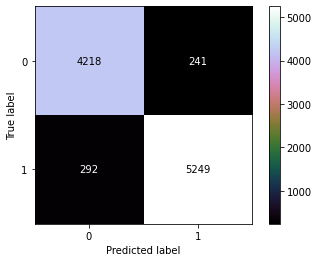

In [28]:
cf_matrix = confusion_matrix(y_test, y_test_pred, labels = [0,1])
cfm_plot = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = [0,1])
cfm_plot.plot(cmap="cubehelix")
plt.show()

## Exporting Trained Model

In [29]:
dump(pipeline,'../models/xgb-clf-pipeline.pkl')

['../models/xgb-clf-pipeline.pkl']